In [1]:
!pip install /Users/johnmount/Documents/work/pyvtreat/pkg/dist/vtreat-0.2.tar.gz
#!pip install https://github.com/WinVector/pyvtreat/raw/master/pkg/dist/vtreat-0.2.tar.gz

Processing /Users/johnmount/Documents/work/pyvtreat/pkg/dist/vtreat-0.2.tar.gz
  Stored in directory: /Users/johnmount/Library/Caches/pip/wheels/4e/08/8e/b5002ac5b5bab82c827ea36eb09ec56c7dc8db2f3dbc435796
Successfully built vtreat
  Found existing installation: vtreat 0.2
    Uninstalling vtreat-0.2:
      Successfully uninstalled vtreat-0.2


In [2]:
import pygam
import pandas
import numpy
import numpy.random
import seaborn
import vtreat
import vtreat.util
import vtreat.transform

In [3]:
class GAMTransform(vtreat.transform.UserTransform):
    """a gam model"""
    def __init__(self):
        vtreat.transform.UserTransform.__init__(self, treatment='gam')
        self.models_ = None

    def fit(self, X, y):
        self.models_ = { 
            v:pygam.LinearGAM().fit(X[[v]], y) 
                for v in X.columns 
                if vtreat.util.can_convert_v_to_numeric(X[v])}
        self.incoming_vars_ = [v for v in self.models_.keys()]
        self.derived_vars_ = [(v + "_gam") for v in self.incoming_vars_]
        return self
        
    def transform(self, X):
        cols = {
            self.derived_vars_[i]:self.models_[self.incoming_vars_[i]].predict(X[[self.incoming_vars_[i]]]) 
                for i in range(len(self.incoming_vars_))}
        return pandas.DataFrame(cols)

In [4]:
d = pandas.DataFrame({'x':[i for i in range(100)]})
d['y'] = numpy.sin(0.2*d['x']) + 0.1*numpy.random.normal(size=d.shape[0])
d.head()

,x,y
0,0,-0.056151
1,1,0.332854
2,2,0.374242
3,3,0.753850
4,4,0.590856


In [5]:
step = GAMTransform()

In [6]:
fit = step.fit_transform(d[['x']], d['y'])
print(step.derived_vars_)
fit['x'] = d['x']
fit.head()

['x_gam']


,x_gam,x
0,0.333381,0
1,0.443822,1
2,0.546538,2
3,0.637836,3
4,0.714022,4


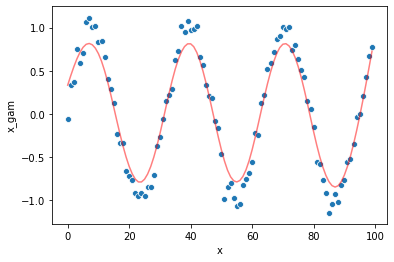

In [7]:
seaborn.scatterplot(x='x', y='y', data=d)
seaborn.lineplot(x='x', y='x_gam', data=fit, color='red', alpha=0.5)

In [8]:
transform = vtreat.NumericOutcomeTreatment(
    outcome_name='y',
    params = vtreat.vtreat_parameters({
       'user_transforms': [GAMTransform()]
    }))

In [9]:
x2 = transform.fit_transform(d, d['y'])

In [10]:
transform.score_frame_

,orig_variable,treatment,variable,y_aware,has_range,PearsonR,significance,vcount,recommended
0,x,clean_copy,x,False,True,-0.186058,6.382361e-02,1.0,True
1,x,gam,x_gam,True,True,0.973091,2.780846e-64,1.0,True


In [11]:
x2.head()

,y,x,x_gam
0,-0.056151,0.0,0.679887
1,0.332854,1.0,0.719058
2,0.374242,2.0,0.562389
3,0.753850,3.0,0.649788
4,0.590856,4.0,0.672417


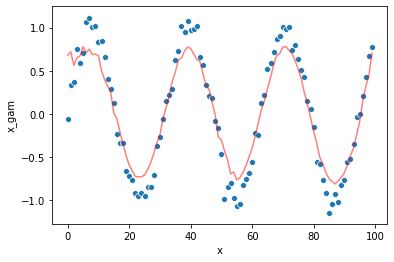

In [12]:
seaborn.scatterplot(x='x', y='y', data=x2)
seaborn.lineplot(x='x', y='x_gam', data=x2, color='red', alpha=0.5)